In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
df = pd.read_csv("data/client_knp.csv")
df.columns = ["client", "knp"]
df.knp = df.knp.str.replace(",", " ")
df["len"] = df.knp.str.split(" ").str.len()

filtered_df = df[(df.len > 2) & (df.len < 50)]

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [67]:
np.percentile(df["len"].values, [80, 99])

array([ 3., 49.])

In [80]:
with open("data/knp_data.txt", "w") as out:
    for row in df.iterrows():
        print(row[1]["knp"], file=out)

In [23]:
%%time

from gensim.models.word2vec import LineSentence
from gensim.models.word2vec import Word2Vec
import multiprocessing


sentences = LineSentence("data/knp_data.txt")

params = {'size': 32, 'window': 4, 'min_count': 10, 
          'workers': 10, 'sample': 1E-3,}
word2vec = Word2Vec(sentences, **params)

CPU times: user 53.5 s, sys: 3.33 s, total: 56.8 s
Wall time: 49.9 s


In [28]:
word2vec.save("data/w2v.model")

In [24]:
vocab = word2vec.wv.vocab.keys()
word_vectors = {key:word2vec.wv[key] for key in vocab}
vectors = [word2vec.wv[key] for key in vocab]

In [25]:
from sklearn.manifold import TSNE

tsne = TSNE()
tr = tsne.fit_transform(vectors)

In [26]:
a = ["white", "black", "yellow", "purple", "orange", "red", "buff", "gray", "green", "blue"]
c = list(map(lambda x: int(x) // 100, vocab))

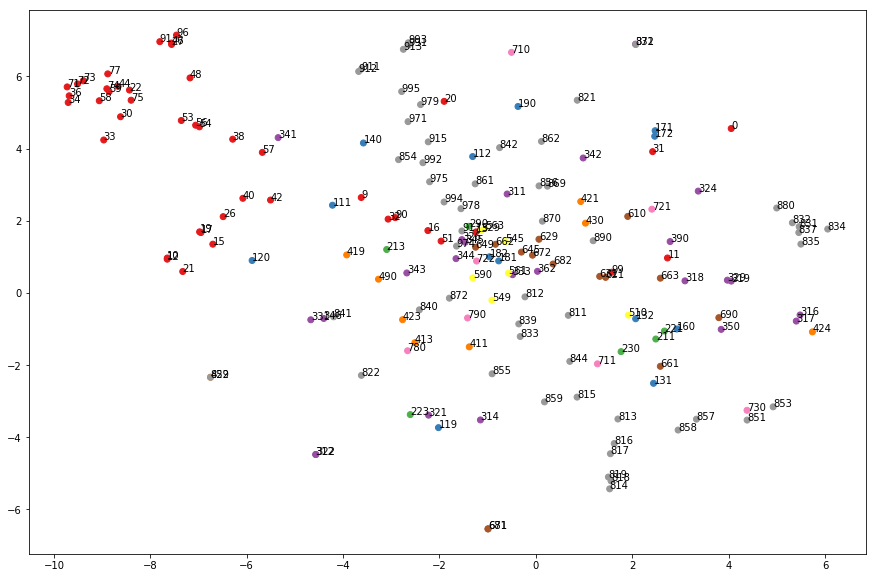

In [27]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(tr[:, 0], tr[:, 1], c=c, cmap="Set1")

for i, txt in enumerate(vocab):
    ax.annotate(txt, (tr[i, 0], tr[i, 1]))

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
_ = tfidf.fit_transform(df.knp)
idfs = {key:tfidf.idf_[value] for key, value in tfidf.vocabulary_.items()}

In [30]:
def get_vector(knps):
    knps = list(filter(lambda knp: knp in word_vectors.keys() and knp in idfs.keys(), knps.split()))
    
    if not knps:
        return np.zeros(shape=vectors[0].shape[0])
    
    tf = 1.0 / len(knps)
    weights = np.array([idfs[knp] * tf for knp in knps])
    knp_vecs = np.array([word_vectors[knp] for knp in knps])
    
    return np.multiply(knp_vecs, weights.reshape(-1, 1)).sum(axis=0)

df["w2v"] = df.knp.apply(get_vector)

In [11]:
df[["client", "w2v"]].to_csv("data/client_w2v.csv", index=False)

In [ ]:
%%time

from sklearn.cluster import DBSCAN

dbscan = DBSCAN()
a = df.sample(250000)
client_vectors = np.vstack(a.w2v.values)
preds = dbscan.fit_predict(client_vectors)

array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 17

In [13]:
%%time

import umap


df1 = df.sample(4000)
clients_tsne = umap.UMAP().fit_transform(np.vstack(df1.w2v.values))

CPU times: user 1min 1s, sys: 1min 5s, total: 2min 6s
Wall time: 55.9 s


In [11]:
%%time

tsne = TSNE()
df1 = df.sample(4000)
clients_tsne = tsne.fit_transform(np.vstack(df1.w2v.values))

CPU times: user 1min 36s, sys: 1min 2s, total: 2min 39s
Wall time: 2min 39s


In [14]:
clients_tsne

array([[ -0.643228  ,   2.46315736],
       [ -1.8329498 ,  -5.3508139 ],
       [  0.7130348 ,  -9.20376232],
       ...,
       [  6.06174998,   4.8735682 ],
       [ -4.07674183, -11.45883614],
       [-11.71735308,  13.63355735]])

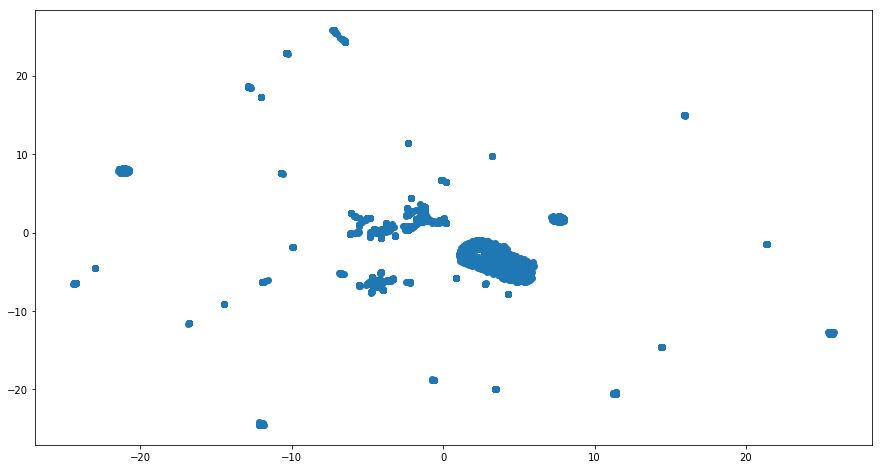

In [14]:
plt.figure(figsize=(15, 8))
plt.scatter(clients_tsne[:, 0], clients_tsne[:, 1])

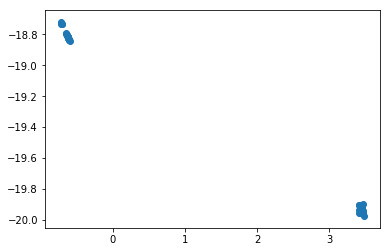

In [21]:
x, y = clients_tsne[:, 0], clients_tsne[:, 1]
x_range = (-20, 0)
y_range = (15, 30)
x_range = (-3, 5)
y_range = (-22, -17)
mask = (x > x_range[0]) & (x < x_range[1]) & (y > y_range[0]) & (y < y_range[1])

plt.scatter(clients_tsne[np.where(mask), 0], clients_tsne[np.where(mask), 1])

In [22]:
df1[mask].knp.value_counts()

314                                                        9
314 314 314                                                8
311 321 321 311 321 321 311 321                            4
314 314                                                    4
314 314 314 314                                            3
314 314 314 314 314                                        2
321 321 321 311 321 321 311 311 311 321 321 311 321        1
321 321 311 311 321 321 321 311                            1
314 314 314 0                                              1
321 321 311 311 311 321 321 321                            1
311 311 321 321 311 321 321 321 311 311 321 321 321        1
311 321 321 321 311 321 321 311                            1
314 314 314 324                                            1
119 314 314 314                                            1
321 311 311 321 321 321 321 311 321 311 321                1
314 0 0                                                    1
314 314 324 314         